In [1]:
import h5py
import json
import numpy as np
import pandas as pd
import padasip as pa

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)
plt.rcParams['axes.grid'] = 'on'

from pathlib import Path
from scipy import signal
from scipy.signal import butter, lfilter
from collections import Counter
from helpers import *

from scipy.signal import butter, sosfilt, sosfreqz

# Dreem Case study

We want to create, train and serve a sleep stage classification model for the
Dreem headband. The headband provides 7 channels of EEG data sampled at 250Hz and accelerometer data sampled at 50Hz. Our goal is to classify 30 seconds of signal as one of the five sleep stages: Wake, N1, N2, N3 (Deep Sleep), and REM (paradoxical sleep).

### Loading the data

Seven records with their associated hypnogram are provided. They are each identified by a unique uuid.

In [2]:
# Paths to data
PATH_TO_DATA = Path("data/h5/")
PATH_TO_HYPNOGRAM = Path("data/hypnograms/")

# List of expected records
records_list =  [
"8e0bf011-1db6-46fa-a3cd-496e60c0de6f",
"d8a9babd-8454-42e9-9286-eb66c996d3e6",
"c5080eac-a388-4b1f-818f-a7f902fe4c06",
"62492470-d4d5-4dee-8030-80cca44fb002",
"87748119-6fff-45d2-9219-888532fb7efd",
"9bd9224a-bbdf-46c2-a494-3bbfcfd7e776",
"8f3dc41c-df99-4a5f-82cf-6b9f6e265b92"
]

# Signal descriptors
EEG_FREQUENCY = 250
EEG_CHANNELS = 7
ACCELEROMETER_FREQUENCY = 50
SIGNALS_DESCRIPTION = [
    {'path':'accelerometer_x','fs':ACCELEROMETER_FREQUENCY},
    {'path':'accelerometer_y','fs':ACCELEROMETER_FREQUENCY},
    {'path':'accelerometer_z','fs':ACCELEROMETER_FREQUENCY},
    {'path':'eeg1','fs':EEG_FREQUENCY},
    {'path':'eeg2','fs':EEG_FREQUENCY},
    {'path':'eeg3','fs':EEG_FREQUENCY},
    {'path':'eeg4','fs':EEG_FREQUENCY},
    {'path':'eeg5','fs':EEG_FREQUENCY},
    {'path':'eeg6','fs':EEG_FREQUENCY},
    {'path':'eeg7','fs':EEG_FREQUENCY},
]

# Target variable encoding
SLEEP_STAGE_ENCODING = {
    "WAKE":0,
    "N1":1,
    "N2":2,
    "DEEP":3,
    "REM":4
}

# Load the data
data_dict = dict()
for record_idx, record in enumerate(records_list):
    record_data = h5py.File(PATH_TO_DATA / f"{records_list[record_idx]}.h5",'r')
    with open(PATH_TO_HYPNOGRAM / f"{records_list[record_idx]}.json",'r') as hypnogram_file:
        hypnogram = json.load(hypnogram_file)
    data_dict[record] = (record_data, hypnogram)

### Exploring the data

Let us visualize the signals for a given night. The hypnogram is what our model needs to output for a given night of measurements.

In [3]:
for record in records_list:
    r, h = data_dict[record]
    n_points = len(r['eeg1'])//(30*EEG_FREQUENCY)
    print(f"Number of 30sec signals = {n_points}, number of labels = {len(h)}")

Number of 30sec signals = 856, number of labels = 850
Number of 30sec signals = 803, number of labels = 803
Number of 30sec signals = 920, number of labels = 920
Number of 30sec signals = 812, number of labels = 812
Number of 30sec signals = 750, number of labels = 750
Number of 30sec signals = 806, number of labels = 806
Number of 30sec signals = 697, number of labels = 526


In [4]:
subject_info = dict()
for record in records_list:
    r, h = data_dict[record]
    subject_info[record] = dict(Counter(h))
df = pd.DataFrame(subject_info).T
df.loc['Total', :] = df.sum()
df.astype(int)

,WAKE,N1,N2,DEEP,REM
8e0bf011-1db6-46fa-a3cd-496e60c0de6f,46,46,311,199,248
d8a9babd-8454-42e9-9286-eb66c996d3e6,72,55,222,207,247
c5080eac-a388-4b1f-818f-a7f902fe4c06,83,41,242,287,267
62492470-d4d5-4dee-8030-80cca44fb002,47,35,253,275,202
87748119-6fff-45d2-9219-888532fb7efd,41,46,305,174,184
9bd9224a-bbdf-46c2-a494-3bbfcfd7e776,49,28,306,186,237
8f3dc41c-df99-4a5f-82cf-6b9f6e265b92,23,22,222,193,66
Total,361,273,1861,1521,1451


The classes are imbalanced in the dataset, there is significantly less (Wake, N1) stages than the others.

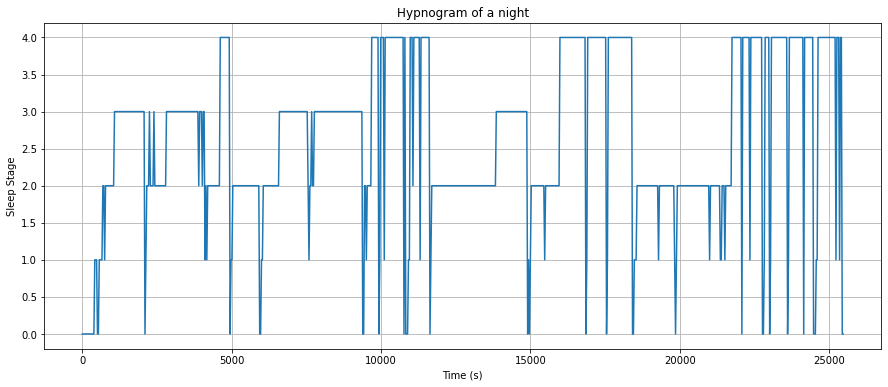

In [5]:
example_record_data, example_hypnogram = data_dict[records_list[0]]

plt.figure(figsize=(15,6))
encoded_hypnogram = [SLEEP_STAGE_ENCODING[x] for x in example_hypnogram]
plt.title("Hypnogram of a night")
plt.plot(np.arange(0,len(encoded_hypnogram)) * 30, encoded_hypnogram)
plt.xlabel('Time (s)')
plt.ylabel("Sleep Stage")
plt.show()

Some of the 30 sec signals do not have labels, we will assume that it's the last ones and we will remove them from the analysis.

#### EEG data

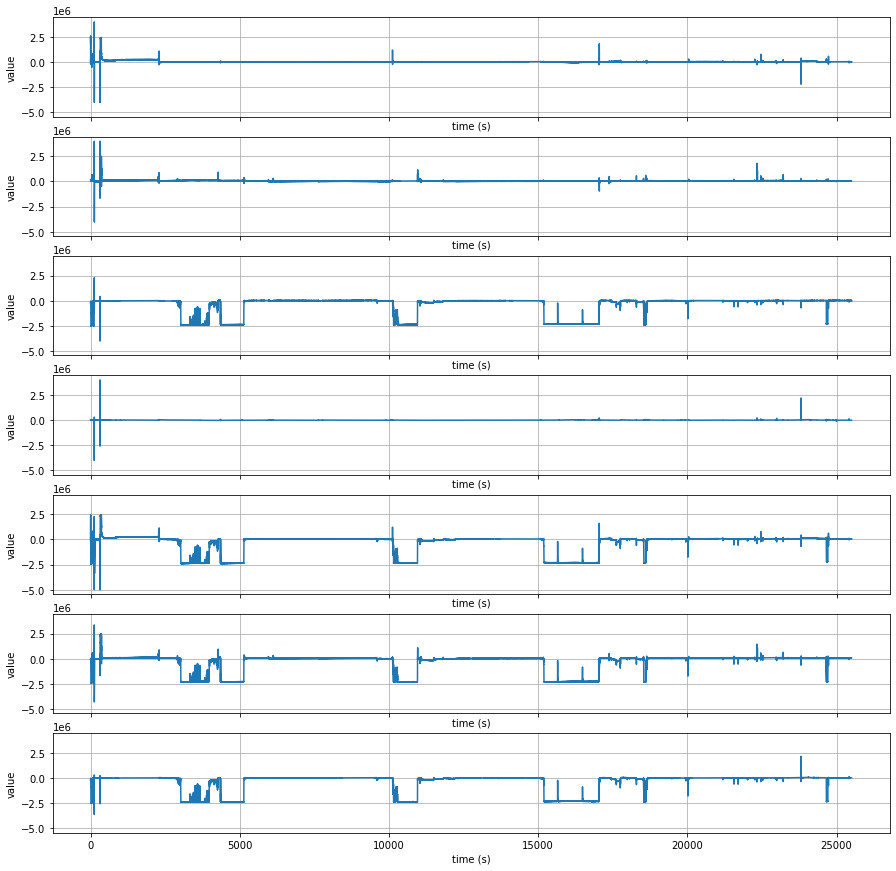

In [6]:
# Raw accelerometer data
max_idx = len(example_hypnogram) * EEG_FREQUENCY * 30
raw_eeg_data = [example_record_data[f'eeg{n}'][:max_idx] for n in range(1, EEG_CHANNELS+1)]

# Plot 3 channels
fig, axes = plt.subplots(EEG_CHANNELS, 1, sharey=True, sharex=True, figsize=(15, 15))
for idx in range(EEG_CHANNELS):
    d = raw_eeg_data[idx]
    axes[idx].plot(np.arange(0, d.shape[0]) / EEG_FREQUENCY, d)
    axes[idx].set_xlabel('time (s)')
    axes[idx].set_ylabel('value')

The raw signal is noisy and we already have information to clean it up: the amplitudes are in a -300 to 300 range and the frequencies between 0.5 and 35Hz. We can clip all values outside of the -300,300 window and normalize signal values.

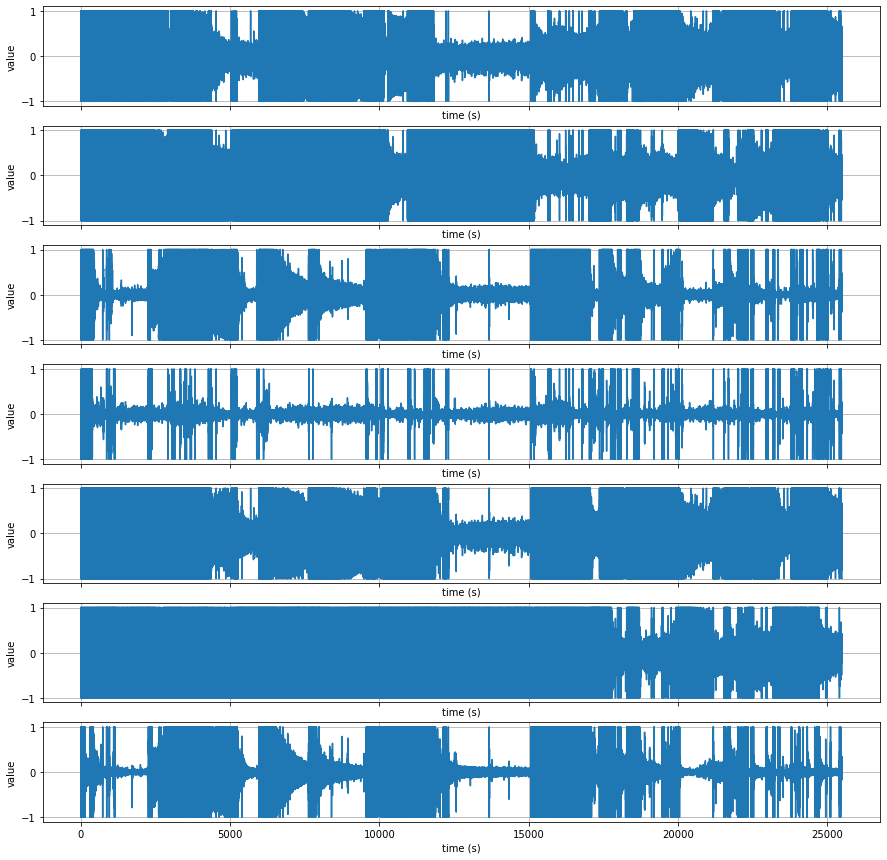

In [33]:
filtered_eeg_data = [
    clip_and_scale(butter_bandpass_filter(axis_data, 0.5, 35, EEG_FREQUENCY, order=1), max_value=300)
    for axis_data in raw_eeg_data
] 

# Plot 3 channels
fig, axes = plt.subplots(EEG_CHANNELS, 1, sharey=True, sharex=True, figsize=(15, 15))
for idx in range(EEG_CHANNELS):
    d = filtered_eeg_data[idx]
    axes[idx].plot(np.arange(0, d.shape[0]) / EEG_FREQUENCY, d)
    axes[idx].set_xlabel('time (s)')
    axes[idx].set_ylabel('value')

For a given eeg signal, there are several frequency bands that are of interest for the sleep stage classification task: Delta (0.5-4Hz), Theta (4-7Hz), Alpha (8-13 Hz), and Beta (14-30 Hz) ([source](http://papersim.com/wp-content/uploads/Biomedical_Engineering_Automatic_Sleep_Stage_Classification_EEG__Neural_Networks_and_Wavelet_Packet_2008.pdf)).

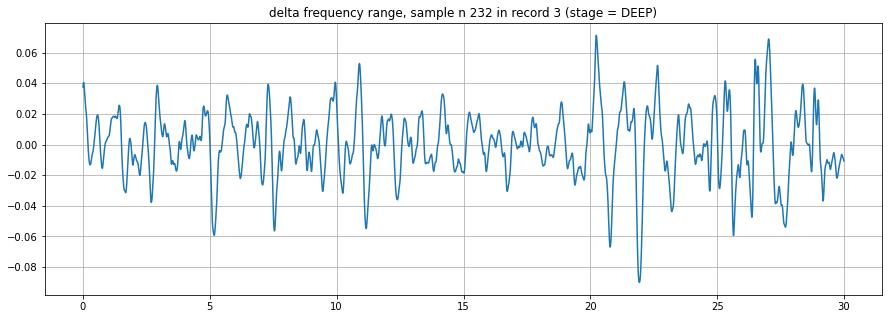

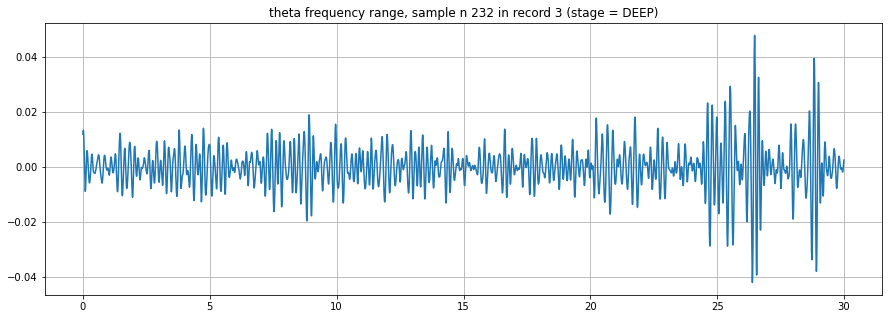

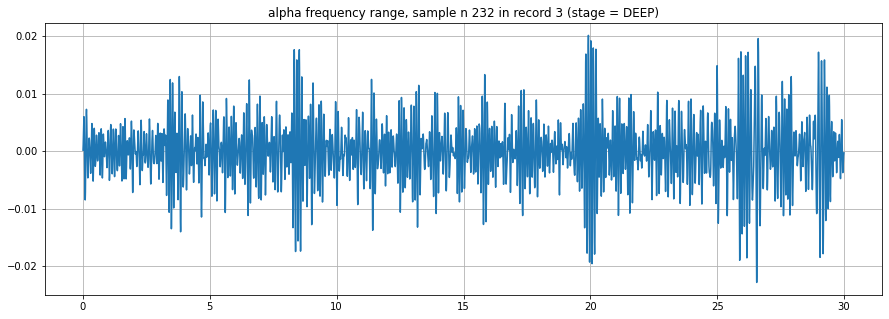

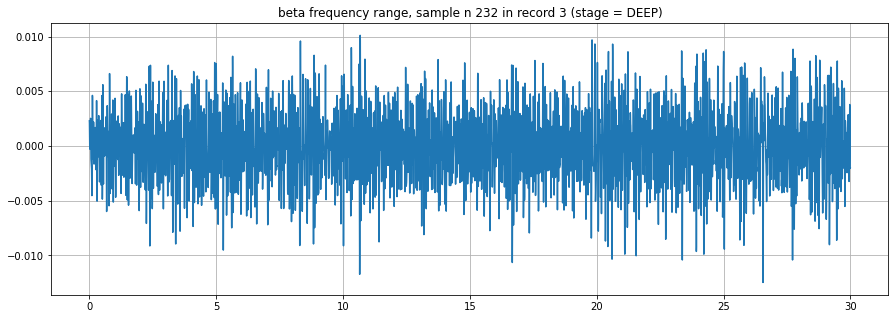

In [34]:
# Example decomposition for a given eeg channel on a 
record_idx = 3
sample_idx_in_record = 232

hypnogram = data_dict[records_list[record_idx]][1]

freq_domains = {
    'delta': [0.5, 4],
    'theta': [4, 7],
    'alpha': [8, 13],
    'beta': [14, 30]
}

for domain in freq_domains.keys():
    l, h = freq_domains[domain]
    d = butter_bandpass_filter(filtered_eeg_data[record_idx], l, h, EEG_FREQUENCY, order=1)
    start = sample_idx_in_record*EEG_FREQUENCY*30
    end = start + EEG_FREQUENCY*30
    d = d[start:end]
    plt.title(f"{domain} frequency range, sample n {sample_idx_in_record} in record {record_idx}\
 (stage = {hypnogram[sample_idx_in_record]})")
    plt.plot(np.arange(0, d.shape[0]) / EEG_FREQUENCY, d)
    plt.show()

The application of the butterworth bandpass filter changes amplitudes in the signal, why? Phase delay ? important ? 

This decomposition won't be used in the model, because I chose to implement a paper which proposes a network working on the eeg signal output. However it seems that several papers point that activity in those bands is related to the sleep stage and can be used as input.

#### Accelerometer data

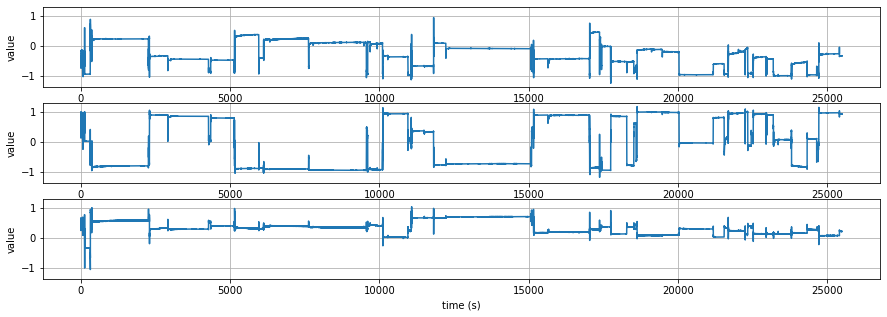

In [35]:
# Get raw accelerometer data and plot
max_idx = len(example_hypnogram) * ACCELEROMETER_FREQUENCY * 30
raw_acc_data = [example_record_data[f'accelerometer_{axis}'][:max_idx] for axis in ['x', 'y', 'z']]
fig, axes = plt.subplots(3, 1, sharey=True)
for i, d in enumerate(raw_acc_data):
    axes[i].plot(np.arange(0, d.shape[0]) / ACCELEROMETER_FREQUENCY, d)
    axes[i].set_xlabel('time (s)')
    axes[i].set_ylabel('value')

The signal looks noisy: similar to the EEG electrode data as mentioned in the case study description, significant accelerometer data probably lies in a certain frequency range.

Since I do not have information about the hardware and what that range is supposed to be, I looked up the [dreem website](https://support.dreem.com/hc/en-us/articles/360021664499-How-to-read-H5-file) and found some information on usable data for research and there as mention of "Raw accelerometer filtered using an order 4 bandpass butterworth between 0.1Hz and 0.5 Hz.". We can work with that.


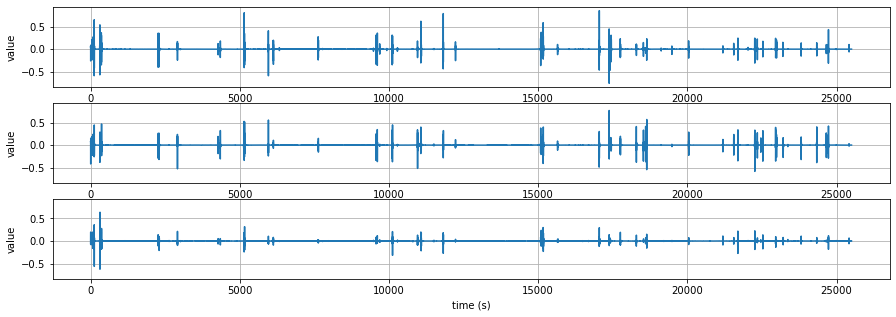

In [36]:
filtered_acc_data = [
    butter_bandpass_filter(axis_data, 0.1, 0.5, 50, order=2) for axis_data in raw_acc_data
]  

fig, axes = plt.subplots(3, 1, sharey=True)
for i, d in enumerate(filtered_acc_data):
    axes[i].plot(np.arange(0, d.shape[0]) / ACCELEROMETER_FREQUENCY, d)
    axes[i].set_xlabel('time (s)')
    axes[i].set_ylabel('value')

Now we could keep ths accelerometer signal as another input modality if we use deep learning to find input feature representations (we can leave the network do the work) or we could try to "correct" EEG data with information from the accelerometer.

#### Adaptive filtering example

In the following [paper](https://www.frontiersin.org/articles/10.3389/fnins.2021.611962/full#h10) a method using adaptive filtering is proposed to remove movement artifacts in EEG data:
- Define d as the noisy signal, y as the movement artifacts, s as the clean signal -> *d = y + s*
- Define x as the accelerometer signal. We want to find distortion weights *W* such that *Wx* approximates *y*, in order to approximate the clean signal with *s ~ s' = d - Wx* 

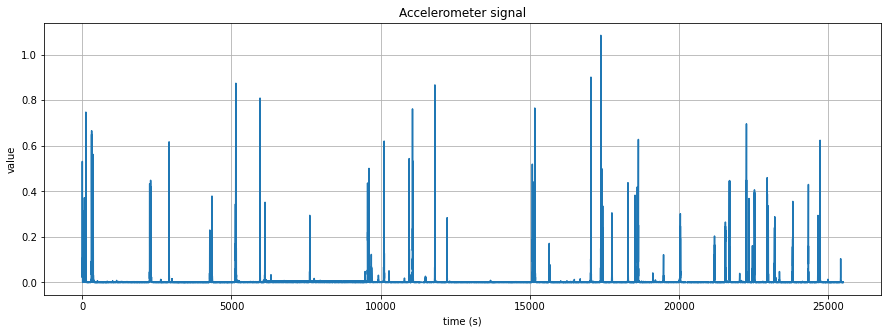

In [37]:
# Define accelerometer signal as l2 norm
accelerometer_signal = np.sqrt(np.sum(np.square(np.array(filtered_acc_data)), axis=0))
plt.plot(np.arange(0, accelerometer_signal.shape[0]) / ACCELEROMETER_FREQUENCY, accelerometer_signal)
plt.title('Accelerometer signal')
plt.xlabel('time (s)')
plt.ylabel('value')
plt.show()

In [38]:
adaptive_filter_size = 100  # 2sec 

# Accelerometer signal, and downsampled eeg signal
x_acc = np.array([accelerometer_signal]).repeat(adaptive_filter_size, axis=0).T
s_noisy = np.mean(filtered_eeg_data[0].reshape(-1, EEG_FREQUENCY // ACCELEROMETER_FREQUENCY), axis=1)

# Run algorithm to estimate movement artifacts
f = pa.filters.FilterNLMS(n=adaptive_filter_size, mu=0.1, w="random")
artifacts, s_clean, w_distortion = f.run(s_noisy, x_acc)

dist = np.linalg.norm(s_noisy - (s_clean + artifacts))
print(f"Euclidean distance between original signal and estimated signal = {dist}")

Euclidean distance between original signal and estimated signal = 6.771572572916863e-15


(0.0, 400.0)

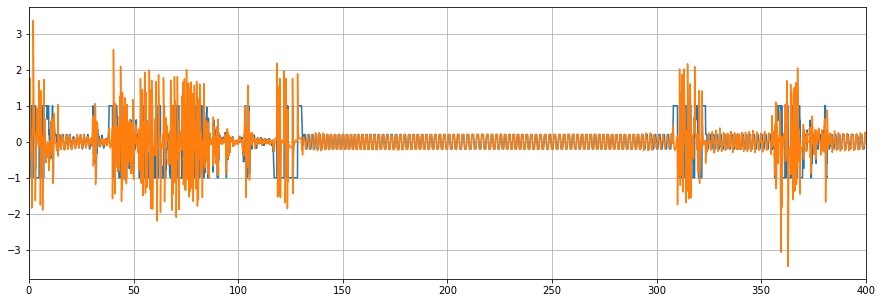

In [39]:
x = np.arange(0, s_noisy.shape[0]) / ACCELEROMETER_FREQUENCY
plt.plot(x, s_noisy)
plt.plot(x, s_clean)
plt.xlim([0, 400])

We will use this in our processing step to remove the accelerometer channels from the final input.